<a href="https://colab.research.google.com/github/udayLab/PAMI/blob/main/notebooks/weightedFrequentPatterns/basic/WFIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Weighted Frequent patterns in Transactional Databases using WFIM

This tutorial has two parts. In the first part, we describe the basic approach to find Weighted Frequent patterns in a transactional database using the WFIM algorithm. In the final part, we describe an advanced approach, where we evaluate the WFIM algorithm on a dataset at different minimum support threshold values.
***

# Prerequisites:

1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.9/883.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 14.1 MB/s eta 0:00:00
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=5731319b913c0e475dec0aa6e16d772d76f39598064809b5f3360f70b5e781c3
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4753 sha256=a2f66ab0ab66d83c52432a3859c9583222746c413faa872a75929521720d49a5
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [5]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/transactionalDatabases/Transactional_T10I4D100K.csv #download a sample transactional database

--2023-11-16 15:52:17--  https://u-aizu.ac.jp/~udayrage/datasets/transactionalDatabases/Transactional_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.95.161.176, 150.31.244.160
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.95.161.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4019277 (3.8M) [text/csv]
Saving to: ‘Transactional_T10I4D100K.csv’

Transactional_T10I4 100%[===================>]   3.83M  1023KB/s    in 5.6s    

2023-11-16 15:52:23 (706 KB/s) - ‘Transactional_T10I4D100K.csv’ saved [4019277/4019277]



3.   Printing few lines of a dataset to know its format.

In [6]:
!head -2 Transactional_T10I4D100K.csv

25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Weighted Frequent patterns using WFIM

### Step 1: Understanding the statistics of a database to choose an appropriate minimum support (minSup) value.

In [7]:
#import the class file
import PAMI.extras.dbStats.TransactionalDatabase as stats

#specify the file name
inputFile = 'Transactional_T10I4D100K.csv'

#initialize the class
obj=stats.TransactionalDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99935
Total number of items : 870
Database sparsity : 0.9883886940304302
Minimum Transaction Size : 1
Average Transaction Size : 10.101836193525791
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667097909135199
Variance in Transaction Sizes : 13.447741640067324


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

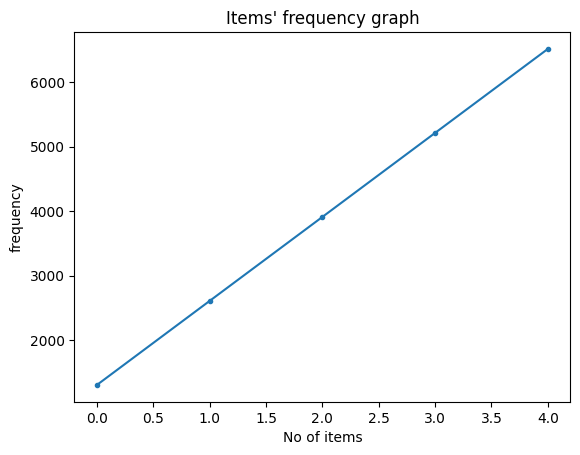

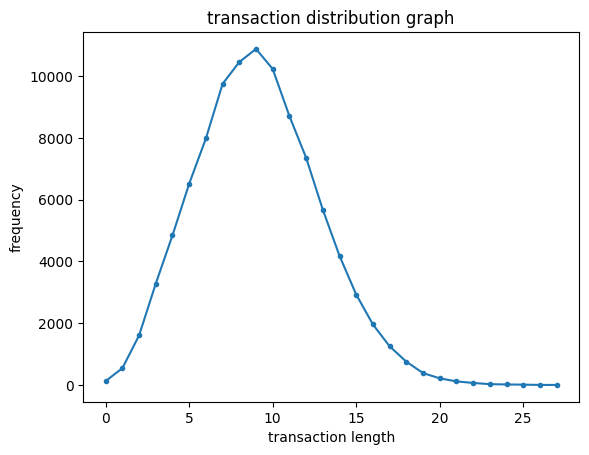

In [8]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 500 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [9]:
minimumSupportCount = 500  #minSup is specified in count. However, the users can also specify minSup between 0 and 1.
weightFile = 'T10_weights.txt'
minWeight = 50

### Step 4: Mining Weighted Frequent patterns using WFIM

In [10]:
from PAMI.weightedFrequentPattern.basic import WFIM as alg #import the algorithm

obj = alg.WFIM(iFile=inputFile, wFile=weightFile, minSup=minimumSupportCount, minWeight=minWeight, sep='\t') #initialize
obj.mine()            #start the mining process

obj.save('weightedFrequentPatternsAtMinSupCount500.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Weighted Frequent patterns were generated successfully using basic algorithm
Total No of patterns: 1066
Runtime: 13.579001188278198
Memory (RSS): 505139200
Memory (USS): 481677312


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [11]:
!head 'weightedFrequentPatternsAtMinSupCount500.txt'

144:505 
771:505 
657:505 
868:510 
934:510 
973:512 
412:516 
194:517 
478:521 
299:522 


The storage format is: _weightedfrequentPattern:support_
***

## Part 2: Evaluating the WFIM algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [12]:
#Import the libraries
from PAMI.weightedFrequentPattern.basic import WFIM as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Transactional_T10I4D100K.csv'
weightFile = 'T10_weights.txt'
seperator='\t'
minWeight = 100
minimumSupportCountList = [100, 200, 300, 400, 500]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of WFIM

In [13]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of WFIM algorithm

### Step 3: Execute the algorithm at different minSup values

In [14]:
for minSupCount in minimumSupportCountList:
    obj = alg.WFIM(inputFile, wFile=weightFile, minSup=minSupCount, minWeight=minWeight, sep=seperator)
    obj.mine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['WFIM', minSupCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Weighted Frequent patterns were generated successfully using basic algorithm
Weighted Frequent patterns were generated successfully using basic algorithm
Weighted Frequent patterns were generated successfully using basic algorithm
Weighted Frequent patterns were generated successfully using basic algorithm
Weighted Frequent patterns were generated successfully using basic algorithm


### Step 4: Print the Result

In [15]:
print(result)

  algorithm  minSup  patterns    runtime     memory
0      WFIM     100     27269  18.978664  559726592
1      WFIM     200     13143  16.936588  536944640
2      WFIM     300      4493  14.226022  531013632
3      WFIM     400      1993  14.631355  521863168
4      WFIM     500      1066  13.545163  511393792


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

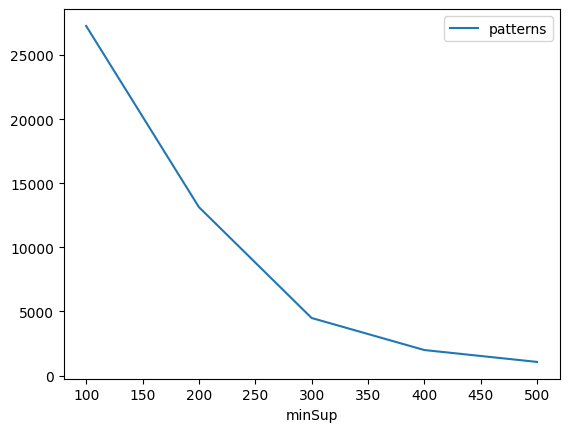

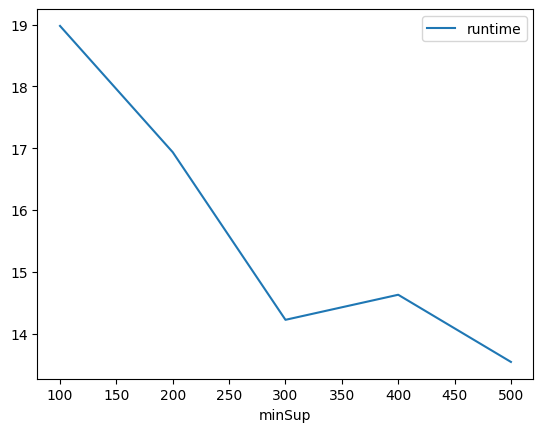

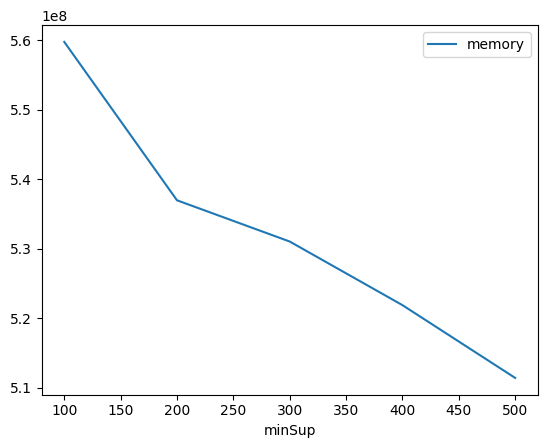

In [16]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib